In [9]:
import json, os, pickle
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)

from mlp import MLP1, MLP2, MLP3, encode_data, fix_random_seed

from mbd_utils import cal_z_exp, generate_disorder, construct_mbl_circuit, calc_imbalance, modify_and_add_noise_to_model

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

# Local, coherent noise
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_coherent, noise_model = modify_and_add_noise_to_model()

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy_coherent = {'shots': 10000, 'backend': backend_noisy_coherent, 'name': 'noisy_coherent'}

In [11]:
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals

In [ ]:
train_circuits, train_ideal_exp_vals, train_noisy_exp_vals = load_circuits('./data/mbd_datasets2/theta_0.05pi/train/', '.pk')
print(len(train_circuits))

test_circuits, test_ideal_exp_vals, test_noisy_exp_vals = load_circuits('./data/mbd_datasets2/theta_0.05pi/val/', '.pk')
print(len(test_circuits))

In [22]:
with open('./data/mbd_datasets2/theta_0.05pi/circuits.pk', 'rb') as infile:
    loaded = pickle.load(infile)

train_circuits = loaded['train_circuits']
test_circuits = loaded['test_circuits']
train_ideal_exp_vals = loaded['train_ideal_exp_vals']
train_noisy_exp_vals = loaded['train_noisy_exp_vals']
test_ideal_exp_vals = loaded['test_ideal_exp_vals']
test_noisy_exp_vals = loaded['test_noisy_exp_vals']

In [24]:
train_noisy_exp_vals = [x[0] for x in train_noisy_exp_vals]
test_noisy_exp_vals = [x[0] for x in test_noisy_exp_vals]
X_train, y_train = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals, num_qubits=4)
X_test, y_test = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals, num_qubits=4)

In [26]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

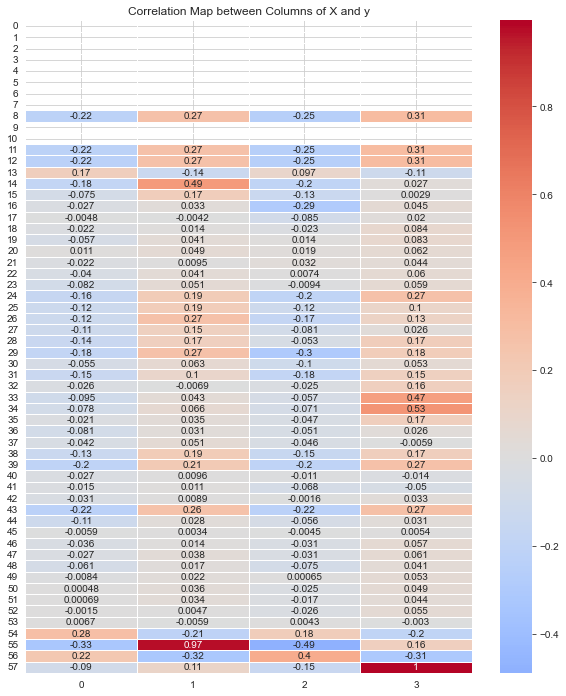

In [40]:
def correlation_map(X, y):
    corr_matrix = np.zeros((X.shape[1], y.shape[1]))
    for i, x_col in enumerate(X.columns):
        for j, y_col in enumerate(y.columns):
            corr_matrix[i, j] = X[x_col].corr(y[y_col])

    return pd.DataFrame(corr_matrix, index=X.columns, columns=y.columns)

correlations = correlation_map(X_train, y_train)

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(10, 12))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, linewidths=.5)
plt.title('Correlation Map between Columns of X and y')
plt.show()

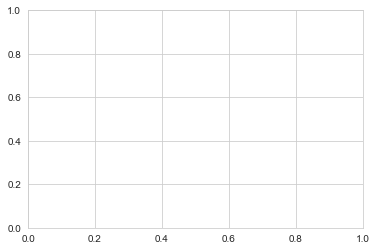

In [42]:
ax = plt.gca()